# <div align="center"><b>Pathway enrichment analysis with DecoupleR-py</b></div>

The last thing we will do in bootcamp (😢) is to perform pathway enrichment analysis using the DecoupleR-py package. This package is incredibly useful for summarizing the results of a differential expression analysis and identifying the biological pathways that are most affected by the changes in gene expression.

This notebook is based on the decoupleR-py tutorial found here: https://decoupler-py.readthedocs.io/en/latest/notebooks/bulk.html

In [1]:
# As usual we will start by importing useful packages
import numpy as np
import pandas as pd
import seaborn as sns

#
import scanpy as sc
import decoupler as dc
from anndata import AnnData

# 1) Load data

In [ ]:
# It can also be useful to specify all your paths here so it is clear where things are coming from
# TODO: Make sure this matches the path of your counts file
path_deseq2 = "scratch/differential_analysis/deseq2_results.csv"
path_out = '~/scratch/pathway_analysis/'

In [4]:
# Load the deseq2 results using pandas
res = pd.read_csv(path_deseq2, index_col=0)  # note that this is actually a csv file because we saved it as such!
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,Symbol
Geneid,,,,,,,,
ENSG00000227232.4,35.027741,1.337082,0.410239,3.259280,0.001117,0.002536,ENSG00000227232,WASH7P
ENSG00000237683.5,59.995128,0.842590,0.296633,2.840513,0.004504,0.009338,ENSG00000237683,NaN
ENSG00000241860.2,28.423092,1.178053,0.438898,2.684118,0.007272,0.014624,ENSG00000241860,AL627309.5
ENSG00000237094.7,87.465975,0.425554,0.239653,1.775712,0.075780,0.122687,ENSG00000237094,NaN
ENSG00000225972.1,46.995998,-0.774459,0.309139,-2.505212,0.012238,0.023611,ENSG00000225972,MTND1P23


/tscc/nfs/home/aklie/opt/miniconda3/envs/2024-mstp-bootcamp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


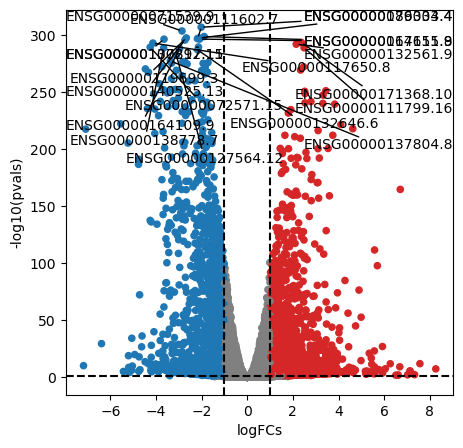

In [5]:
# As a sanity check, let's look at the volcano plot again to make sure it matches the last notebook
dc.plot_volcano_df(
    res,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(5, 5),
    sign_thr=0.05,
    lFCs_thr=1,
)

In [ ]:
# We again need to clean up clean up the dataframew to use symbols as the index to match the decoupler database
res.set_index("Symbol", inplace=True)
res = res[~res.index.isna()]
res = res[~res.index.duplicated()]
mat = res[['stat']].T.rename(index={'stat': 'Persister.vs.Parental'})
mat

# 2) Look for enrichment of PROGENy pathways

PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

Androgen: involved in the growth and development of the male reproductive organs.

EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells

Estrogen: promotes the growth and development of the female reproductive organs.

Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.

JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.

MAPK: integrates external signals and promotes cell growth and proliferation.

NFkB: regulates immune response, cytokine production and cell survival.

p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.

PI3K: promotes growth and proliferation.

TGFb: involved in development, homeostasis, and repair of most tissues.

TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.

Trail: induces apoptosis.

VEGF: mediates angiogenesis, vascular permeability, and cell migration.

WNT: regulates organ morphogenesis during development and tissue repair.

In [ ]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


In [ ]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

Running mlm on mat with 1 samples and 17007 targets for 14 sources.


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
Persister.vs.Parental,-2.814406,-6.663426,0.677134,6.390394,0.116835,-12.904999,1.167528,-12.271215,2.908719,0.027806,2.886794,-1.770708,0.012269,11.876383


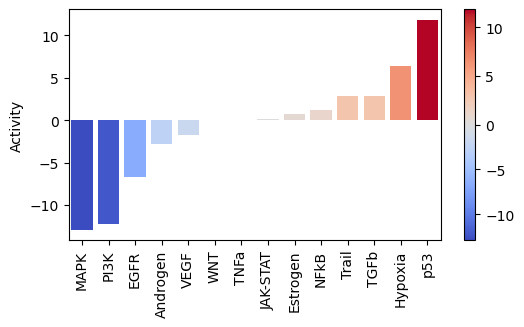

In [ ]:
# We can now plot the pathway activity scores as a barplot
dc.plot_barplot(
    pathway_acts,
    'Persister.vs.Parental',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

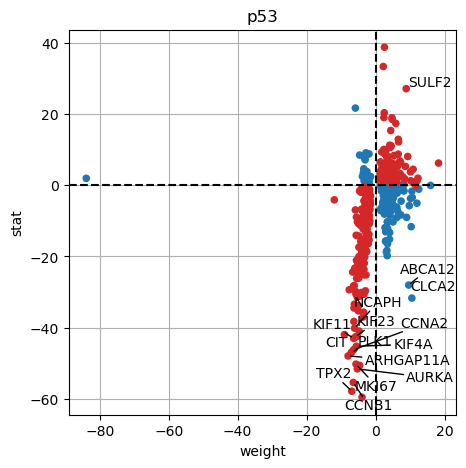

In [ ]:
# We can even look at the specific genes in a pathway and what their weights are
dc.plot_targets(res, stat='stat', source_name='p53', net=progeny, top=15)

# Functional enrichment of biological terms in MSigDB

The Molecular Signatures Database (MSigDB) is a resource containing a collection of gene sets annotated to different biological processes. This will likely be discussed in more detail on the final day of bootcamp, but for now we will use the MSigDB gene sets to perform functional enrichment analysis.

In [ ]:
# Grab the MSigDB database using the decoupler package
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


Not every geneset in msigdb is useful for every analysis, so we will use the gene sets that are most relevant to our data. For this example we will use hallmark genesets

In [ ]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

/tmp/ipykernel_2077225/2098377670.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['IL2_STAT5_SIGNALING', 'COAGULATION', 'HYPOXIA', 'TNFA_SIGNALING_VIA_NFKB', 'COMPLEMENT', 'HYPOXIA', 'P53_PATHWAY', 'TNFA_SIGNALING_VIA_NFKB', 'GLYCOLYSIS', 'APOPTOSIS', 'IL2_STAT5_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB', 'TNFA_SIGNALING_VIA_NFKB', 'EPITHELIAL_MESENCHYMAL_TRANSITION', 'IL2_STAT5_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB', 'TNFA_SIGNALING_VIA_NFKB', 'PROTEIN_SECRETION', 'ADIPOGENESIS', 'BILE_ACID_METABOLISM', 'INFLAMMATORY_RESPONSE', 'INFLAMMATORY_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB', 'UNFOLDED_PROTEIN_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB', 'IL2_STAT5_SIGNALING', 'P53_PATHWAY', 'TNFA_SIGNALING_VIA_NFKB', 'TGF_BETA_SIGNALING', 'KRAS_SIGNALING_UP', 'UV_RESPONSE_UP', 'APOPTOSIS', 'TNFA_SIGNALING_VIA_NFKB', 'APOPTOSIS', 'ALLOGRAFT_REJECTION', 'INTERFERON_GAMMA_RESPONSE', 'INTERFERON_ALPHA_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB',

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,PANCREAS_BETA_CELLS
1450526,GCG,hallmark,PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,PANCREAS_BETA_CELLS


In [ ]:
# We use only significant differentially expressed genes for the analysis
top_genes = res[res['padj'] < 0.05]

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.730000,2.014553e-06,7.194831e-06,1.283906,1.683858e+01,ABCA1;ABCB8;ACADL;ACLY;ACO2;ACOX1;ADCY6;ADIPOR...
1,ALLOGRAFT_REJECTION,200,0.350000,1.000000e+00,1.000000e+00,0.613713,5.361270e-11,AARS1;ABCE1;ACHE;ACVR2A;AKT1;APBB1;B2M;BCL10;B...
2,ANDROGEN_RESPONSE,100,0.840000,7.604226e-09,3.456466e-08,1.476745,2.760710e+01,ABCC4;ACSL3;ACTN1;ADAMTS1;ADRM1;AKAP12;AKT1;AN...
3,ANGIOGENESIS,36,0.555556,6.400262e-01,8.649003e-01,0.984066,4.391356e-01,APP;CCND2;COL5A2;FGFR1;FSTL1;JAG1;JAG2;LRPAP1;...
4,APICAL_JUNCTION,200,0.585000,3.685219e-01,5.419440e-01,1.027111,1.025319e+00,ACTB;ACTG1;ACTN1;ACTN4;ADAM15;ADAM9;AKT2;AKT3;...


In [ ]:
# Run functional enrichment analysis with ORA
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)
enr_pvals.head()

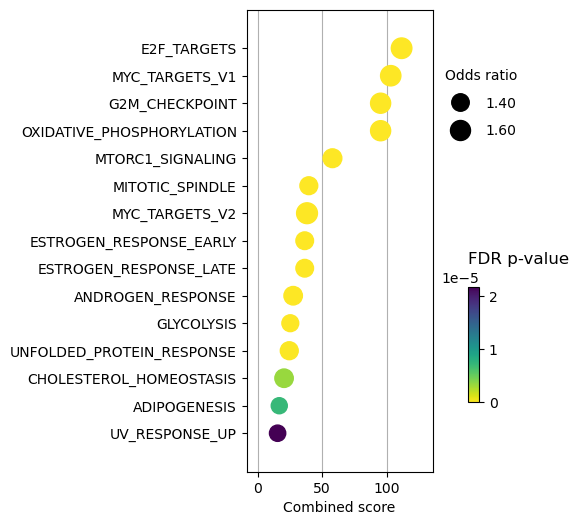

In [ ]:
# Plot a dotplot of the top 15 enriched pathways
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=1.5,
    figsize=(3, 6)
)

Note that the above dotplot tells us that a pathway is enriched but does not tell us if it is up or downregulated. To get a better view of this, we can plot something called a running score:

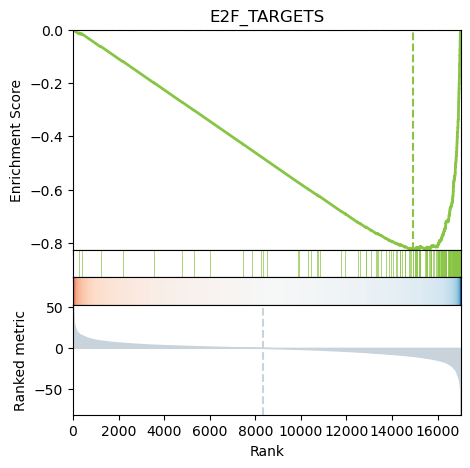

In [ ]:
# Plot running score for E2F_TARGETS
dc.plot_running_score(
    df=res,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='E2F_TARGETS'
)

In [ ]:
# Try to find one with a positive score
dc.plot_running_score(
    df=res,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='E2F_TARGETS'
)

# 5) Some potential exercises

1. What pathways are enriched in only the upregulated genes? In only the downregulated genes?
2. Try different gene sets other than hallmark. What are the differences? Do you notice any trends?


# DONE!

---